In [81]:
# basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")
from dis import dis

# ML
from scipy import stats
import joblib
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from sktime.forecasting.arima import AutoARIMA

df = pd.read_csv("nvda-history.csv");

## Introduction

Using univariate time-series price data, we aim to predict a stock's price in the following 14 days. We examine the efficacy of both ARIMA and LGBM models in prediction accuracy with validation by the RMSE metric.


We start by examining the **stationarity** of our time-series. Stable mean and variance are necessary for linear models such as ARIMA. Hence, we showcase autocorrelation (ACF) and partial autocorrelation (PACF) of our time-series. We then perform an Augmented Dickey-Fuller unit test to examine stationarity.

In [82]:
def tsplot(y, lags = None, figsize=(12,8)):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))

    y.plot(ax = ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots \n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

From the trend of price over time, we observe little movement in price pre-2015. Given the current market's relatively higher levels of volaility, we decide to focus on the past 3 years of data. We also choose a shorter timeframe for backtesting to prevent overfitting to NVDA's price data.

In [83]:
def featuring_train(data):
    # use data from 2020 only
    data = data[data.Date>"2020-01-01"]

    data.reset_index(inplace=True)
    data = data.drop(['index', 'Dividends', 'Stock Splits'],axis=1)

    # basic calculated features
    data['Date'] = pd.to_datetime(data['Date'])
    data['Daily_Range'] = data['Close'] - data['Open']
    data['Mean'] = (data['High'] + data['Low']) / 2
    data['Mean'] = data['Mean'].astype(int)
    
    # set target column y to close
    data['y'] = data['Close']

    # standardization
    data['Open'] = stats.zscore(data['Open'])
    data['High'] = stats.zscore(data['High'])
    data['Low'] = stats.zscore(data['Low'])
    data['Close'] = stats.zscore(data['Close'])
    data['Volume'] = stats.zscore(data['Volume'])
    data['Daily_Range'] = stats.zscore(data['Daily_Range'])
    data['Mean'] = stats.zscore(data['Mean'])

    return data

In [84]:
df = featuring_train(df)

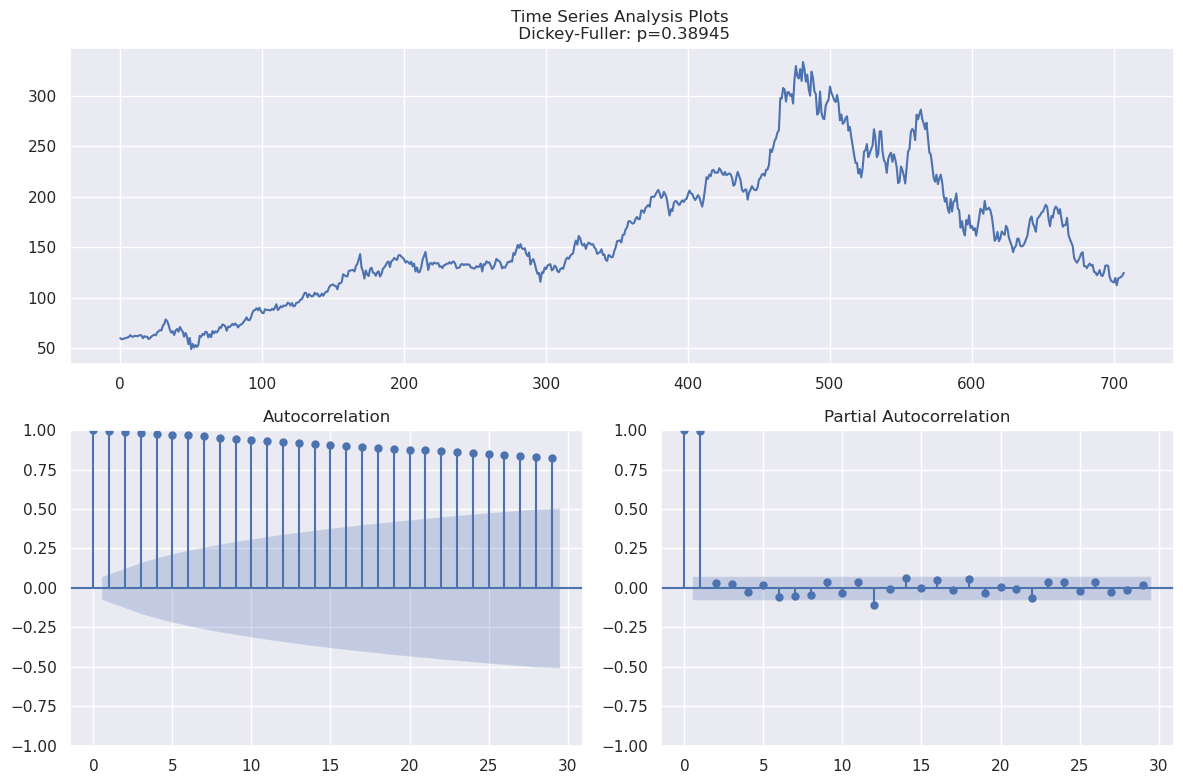

In [85]:
y = df.y
tsplot(y)

As our null hypothesis is "Closing prices are non-stationary", a p-value of 0.67 is not low enough to reject our null hypothesis. Hence, we take the first difference to make the series more stationary.

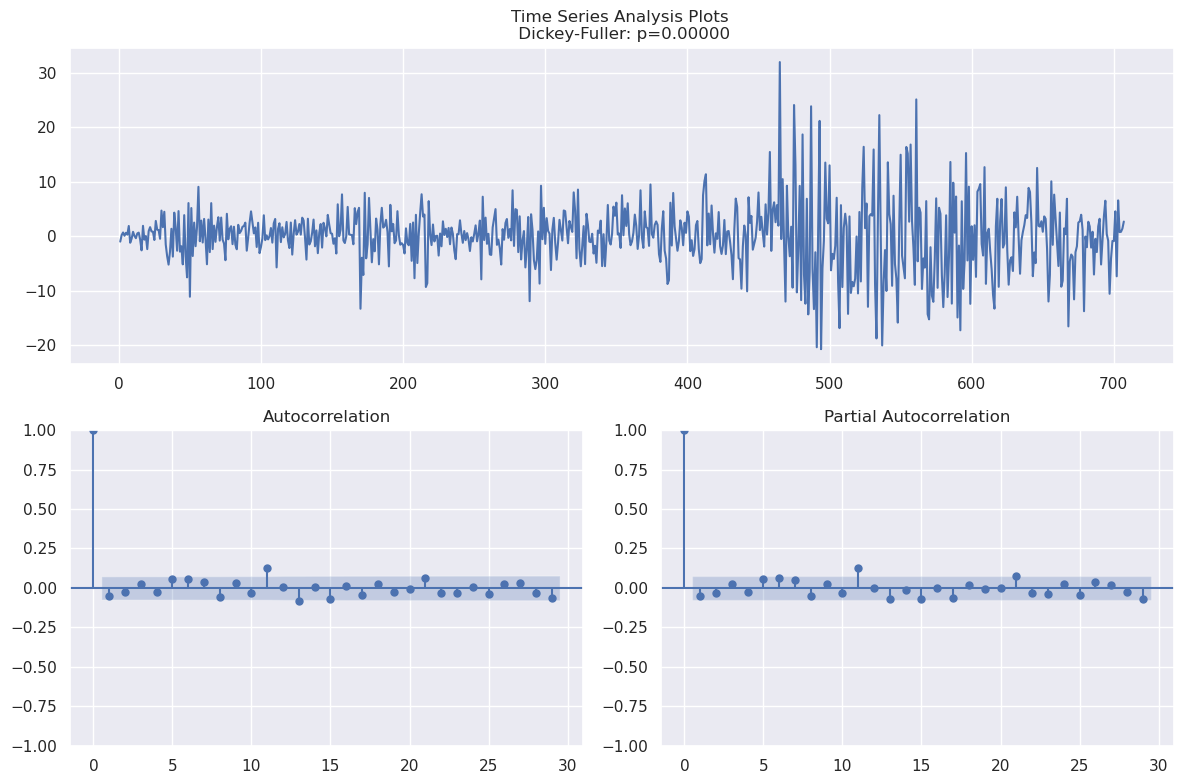

In [86]:
closing_diff = (y - y.shift(1)).dropna()
tsplot(closing_diff)

As there are only significant values up until lag 1 in the PACF plot, we set p=1. As we achieved a stationary time-series with difference 1, we set d=1. To determine q, i.e. the order to set on moving average, it is much harder to determine. Hence, we resort to our AutoARIMA model.

We observe that we have (1,1,2) as our p,d,q parameters.

In [87]:
test_len = int(len(y)*0.2)
price_train, price_test = y.iloc[:-test_len], y.iloc[-test_len:]

# AutoARIMA finds optimal parameters for the ARIMA model
arima_forecaster = AutoARIMA()
arima_forecaster.fit(price_train)
arima_forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  567
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1785.969
Date:                Sun, 23 Oct 2022   AIC                           3581.937
Time:                        21:14:47   BIC                           3603.630
Sample:                             0   HQIC                          3590.404
                                - 567                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6053      0.352      1.718      0.086      -0.085       1.296
ar.L1         -0.6013      0.165     -3.653      0.000      -0.924      -0.279
ma.L1          0.5397      0.161      3.352      0.001       0.224       0.855
ma.L2         -0.1254      0.032     -3.977      0.000      -0.187      -0.064
sigma2        32.2312      1.102     29.240      0.000      30.071      34.392
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               487.28
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.68   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

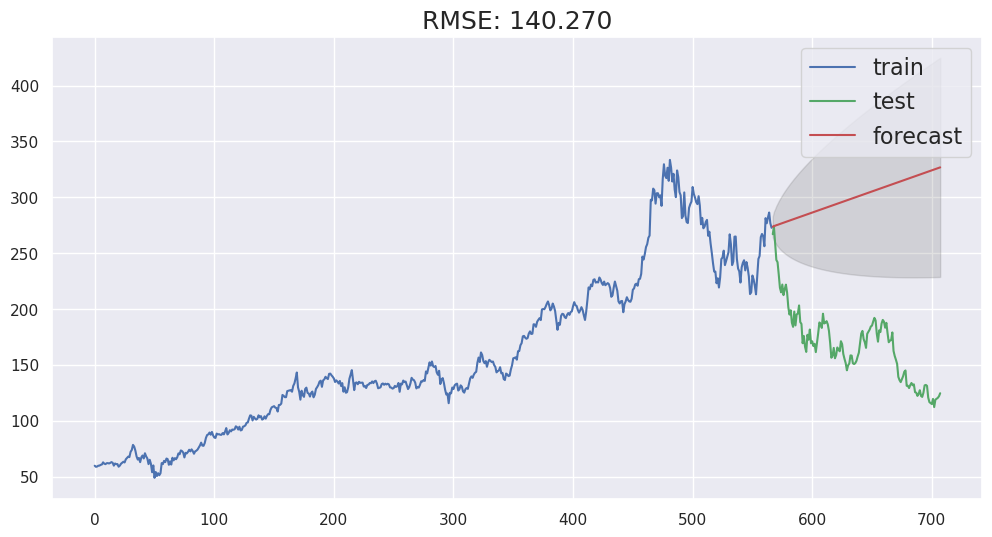

In [88]:
# Data Validation
def plot_forecast(series_train, series_test, forecast, forecast_int=None):
    rmse = mean_squared_error(series_test, forecast, squared=False)

    plt.figure(figsize=(12,6))
    plt.title(f"RMSE: {rmse:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast_index = series_test.index
    forecast.plot(label="forecast", color="r")

    if forecast_int is not None:
        forecast_int = forecast_int["Coverage"][0.9]
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray"
        )

    plt.legend(prop={"size": 16})
    plt.show()

    return rmse
 
fh = np.arange(test_len) + 1
forecast = arima_forecaster.predict(fh=fh)
forecast_interval = arima_forecaster.predict_interval(fh=fh)
arima_rmse = plot_forecast(price_train, price_test, forecast, forecast_interval)


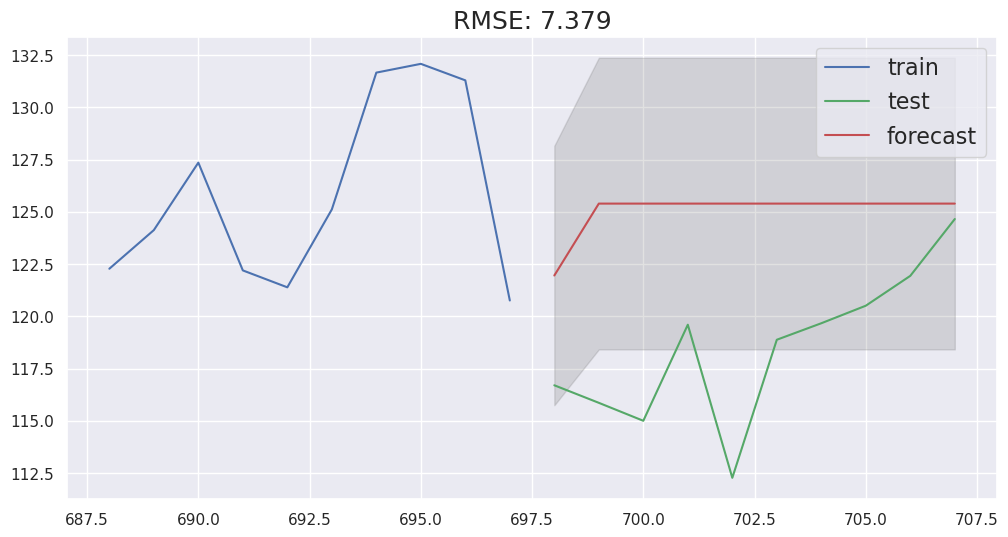

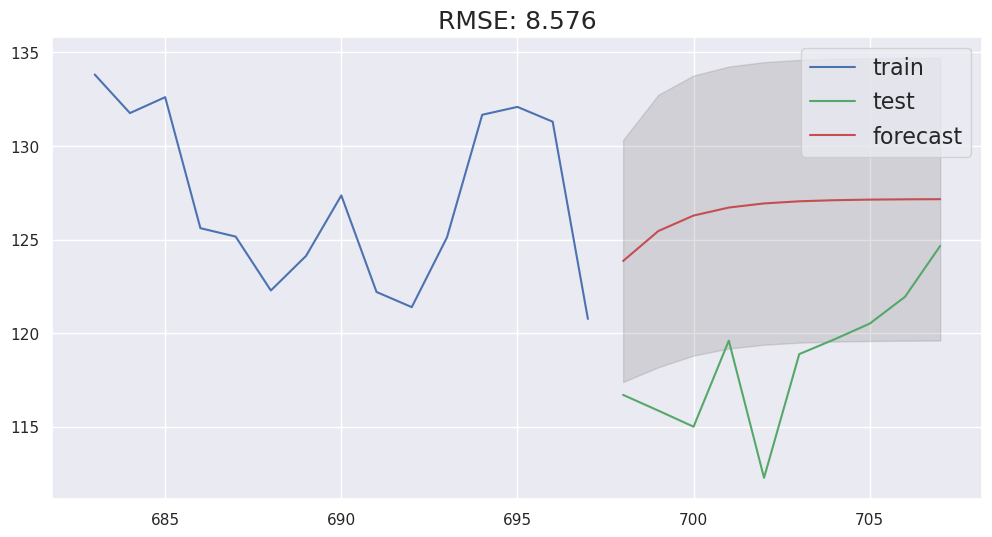

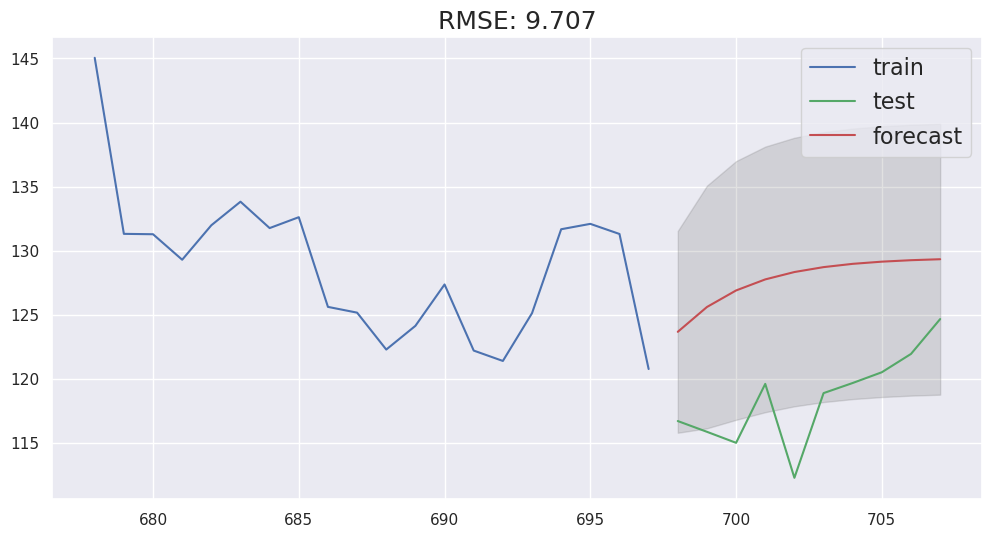

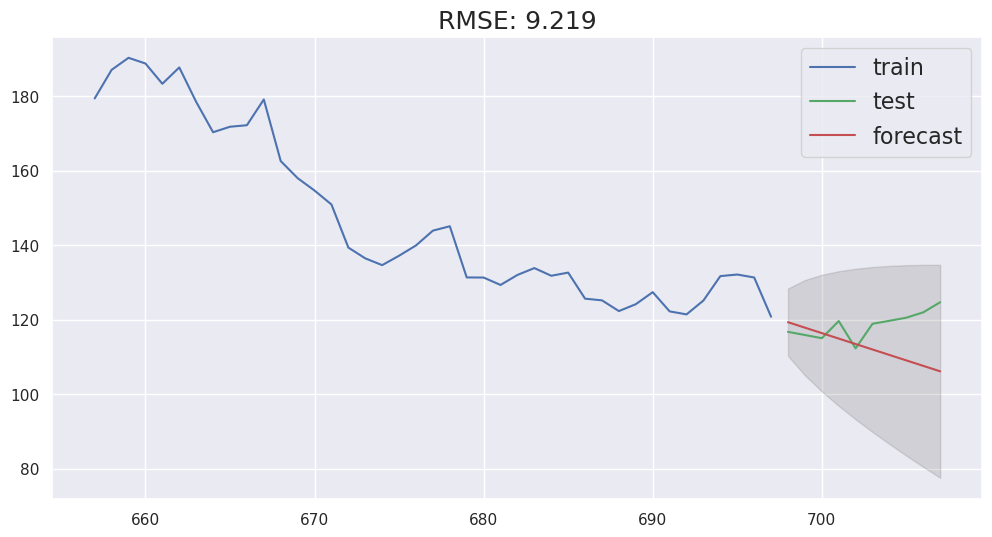

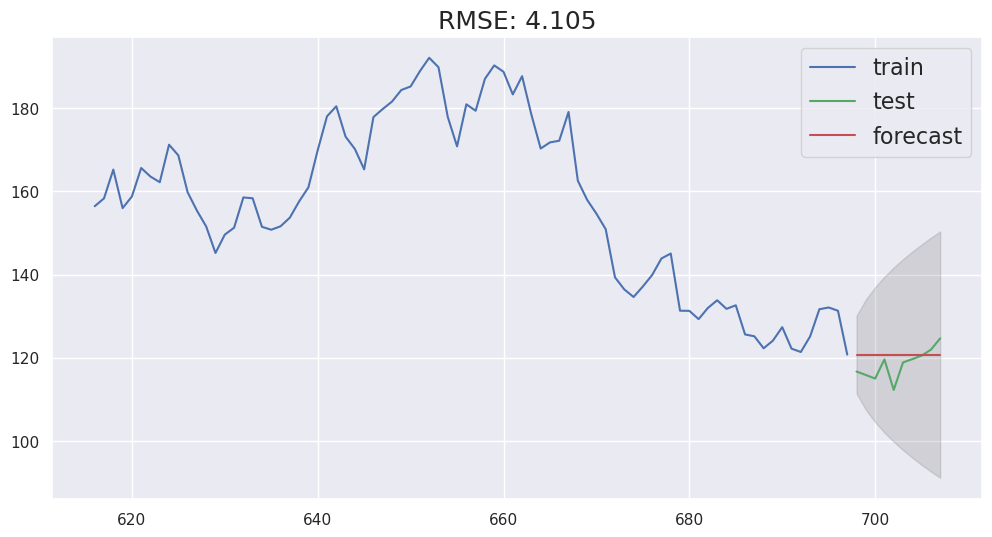

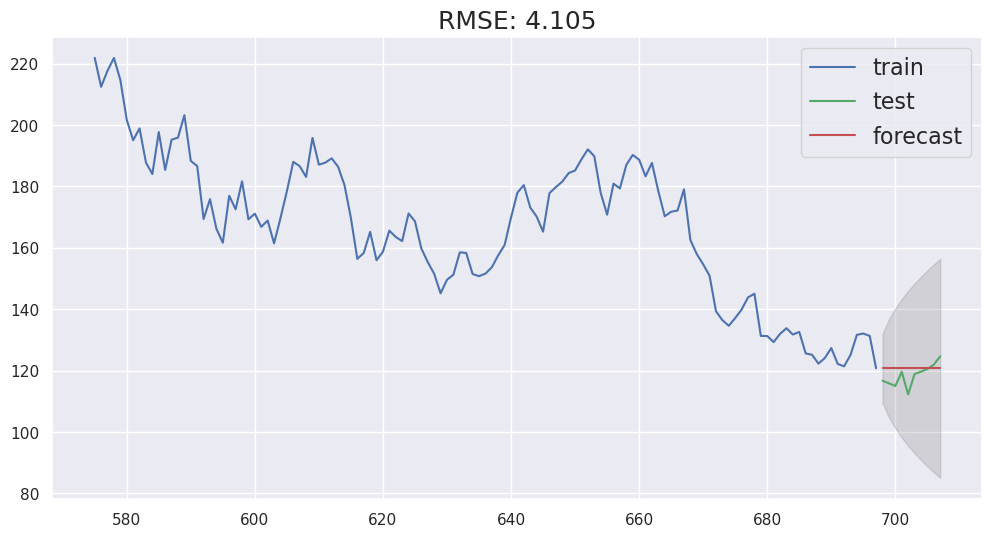

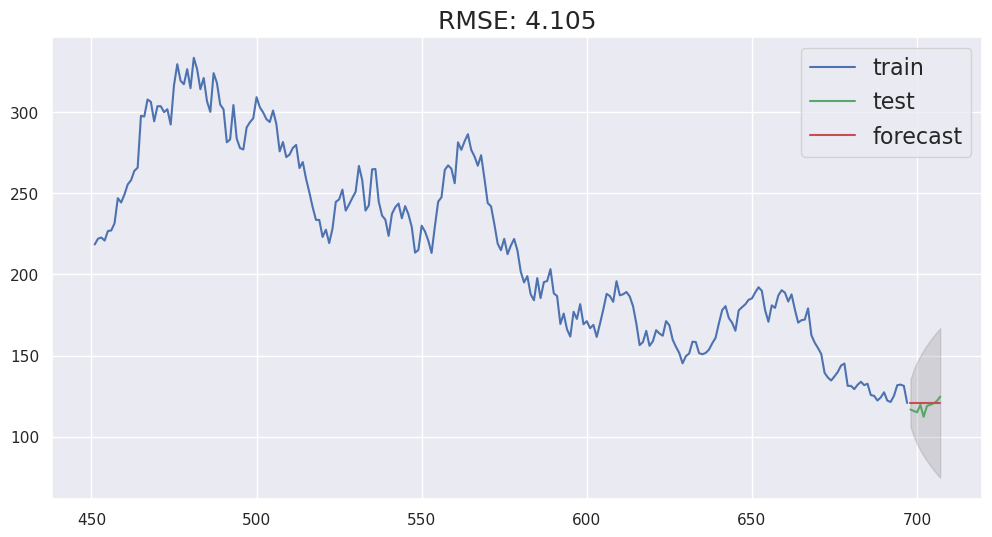

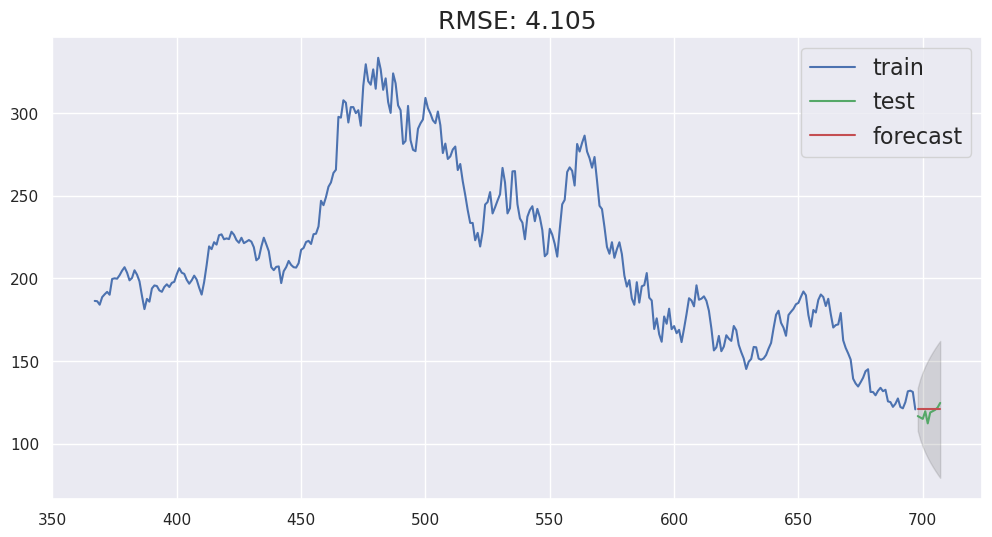

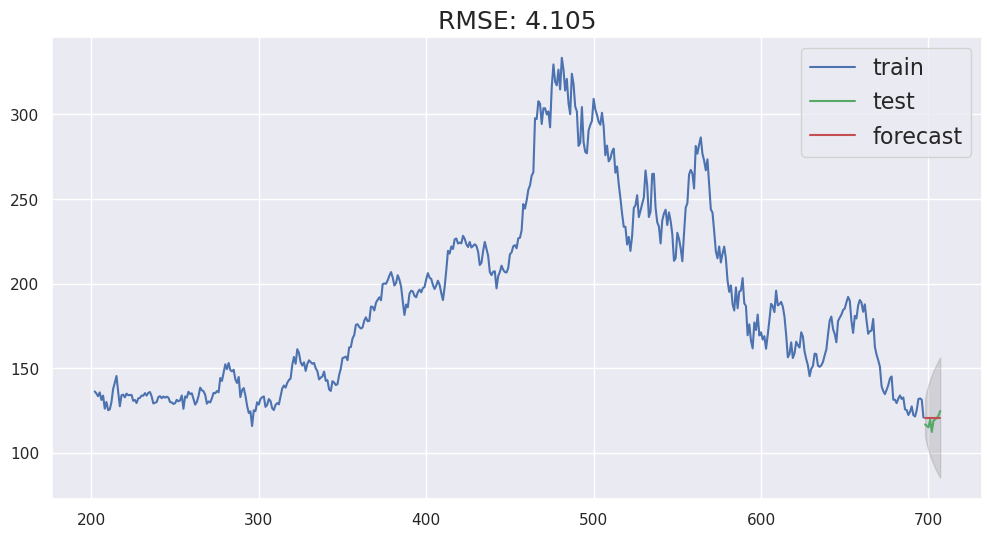

In [89]:
lookback_periods = [14,21,28,60,120,180,360,480,720]
rmse_dict = {}

for lookback in lookback_periods:
    lookback_date = pd.to_datetime(date.today() - timedelta(days=(lookback + 14)))
    arima_y = df[df.Date > lookback_date].y

    test_len = 10
    arima_price_train, arima_price_test = arima_y.iloc[:-test_len], arima_y.iloc[-test_len:]
    arima_forecaster.fit(arima_price_train)

    fh = np.arange(test_len) + 1
    forecast = arima_forecaster.predict(fh=fh)
    forecast_interval = arima_forecaster.predict_interval(fh=fh)
    arima_rmse = plot_forecast(arima_price_train, arima_price_test, forecast, forecast_interval)
    rmse_dict[lookback] = arima_rmse

### Results from Backtesting ARIMA

If our goal is to predict longer term data (>14 days), ARIMA seems to perform better when we train the model on shorter timeframes. There could be multiple reasons for this.

Firstly, ARIMA as a model is used to predict univariate data and performs much better on seasonal and trend-based data. By the nature of OHLC data, there is little scientific literature on the feasiblility of prediciting price over a relatively longer period of time (weeks); owing to the chaotic and noisy characteristics of time-series price data. Hence, we would expect the ARIMA model to fail to capture any trends and/or seasonality in our price data. 

Secondly, When we use longer timeframes as input, the ARIMA model fits to the long term trend of the model. This is most obvious when we fit our data from the start 2020 to April 2022. This period experienced overall long term growth of about 360%. This led to our model predicting an upward trend. However, as clearly seen in our test data, the price of NVDA has only been on a decline ever since. Therefore, the convergence in our forecasted and test prices demonstrate that the ARIMA model does not work on long term chaotic data.

#### Predict T+14 days

If we aim to predict the price 14 days in advance, ARIMA performs better on longer timeframes. This is due to ARIMA developing a linear regression that has a gradient of 0. A more accurate model is obtained by simply choosing a single price and sticking to it for the next 14 days.

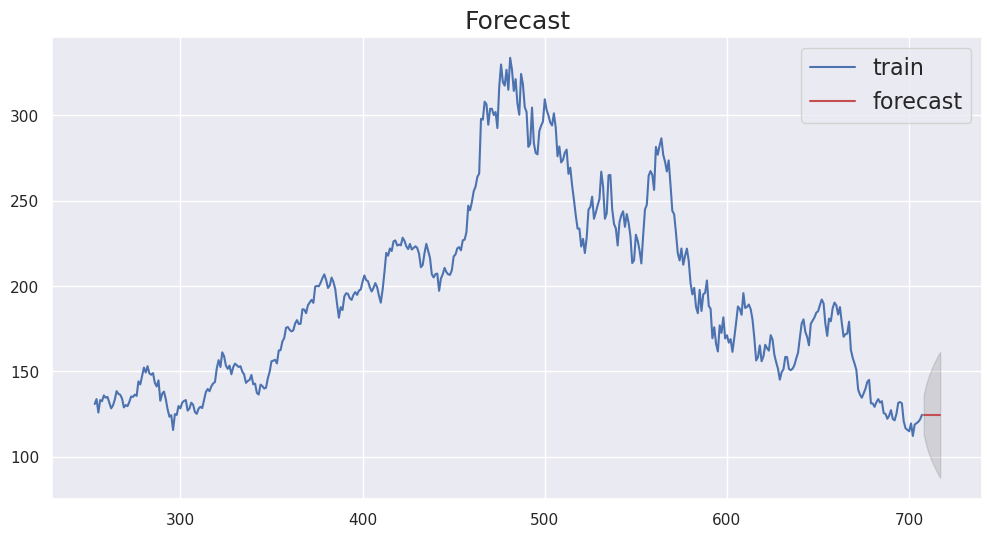

In [90]:
# Getting forecasts from near-term NVDA price data

# Make predictions on recent data
st_price_data = df[df.Date > "2021-01-01"].y
arima_forecaster.fit(st_price_data)
fh = np.arange(10) + 1
forecast = arima_forecaster.predict(fh=fh)
forecast_interval = arima_forecaster.predict_interval(fh=fh)

def plot_actual_forecast(series_train, forecast, forecast_int=None):

    plt.figure(figsize=(12,6))
    plt.title(f"Forecast", size=18)
    series_train.plot(label="train", color="b")
    forecast.plot(label="forecast", color="r")

    if forecast_int is not None:
        forecast_int = forecast_int["Coverage"][0.9]
        plt.fill_between(
            forecast.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray"
        )

    plt.legend(prop={"size": 16})
    plt.show()

plot_actual_forecast(st_price_data, forecast, forecast_interval)


In [91]:
# Export ARIMA Predictions
forecast = forecast.reset_index(drop=True)
forecast.index.name = "Index"
forecast.name = "Close"
forecast.to_csv("arima-predictions.csv")

## Ensembling ARIMA & LGBM

We have decided not to ensemble our predictions because doing so simply increases the RMSE.

This is because both predictions are linearly dependent on each other. The ARIMA model will choose the most current price and forecast it to all 14 days. The LGBM model seems to find some price from some a recursive lookback on some window length, and forecasts it to all 14 days. However, as our LGBM model performed worse than a naive forecast, we have simply decided to go with the ARIMA model baseline forecasts.

## Conclusion

In trying to predict future prices over 14 days, we have determined that the ARIMA and LGBM models perform equal to or worse than a naive forecast. 

When fed with short-term data to medium-term data, the ARIMA models picks up more trends from the data but generates a higher RMSE. 

Models tend to perform better when trained on short-term data as the high variance of prices generate too much noise for any signal to be picked up by both models. This leads to models simply forecasting a fixed price based on the recent days' prices. Likewise, the 

When fed with long-term data, the high variance of prices prevented any pattern from being detected by the ARIMA model. The abundance of noise resulted in the ARIMA model performing a naive forecast, achieving the lowest RMSE.

We also observe a similar trend for in the LGBM model where longer timeframes led to more stable predictions; this does not apply to our shortest timeframe used where RMSE was lowest.

Given this issue of timeframes, we could have implemented whole-market features. For instance, models could also take into account whether the market is increasing or decreasing, and calm or volatile. Developing a self-adapting strategy could lead to more useful models.


## Limitations

Firstly, due to a lack of time, proper cross-validation of our data was not done to properly assess our models. For instance, we should have used a Time Series split to validate our model's performance in forecasting across multiple 14 day timeframes. This would have allowed us to gain further insights into the efficacy of our models.

Secondly, using daily timeseries data to train our models yielded too high of a variance for any meaningful analysis to be conducted. As we aim to predict future price within 14 days, a lower variance could result in more patterns being found by the models. This could allow for more accurate models to be trained.

Finally, the RMSE as the sole metric in determining a model's accuracy is ineffective given daily price data. This incentivises models that predict more stable prices to be chosen. Hence, due to the high variance in daily price data, models tend toward the naive forecast.

Furthermore, the RMSE  fails to capture application of stock price prediction to the larger context of trading the stock. 

Let the difference between the predicted and actual price be $x. In the event of selling at a loss of $x, a portfolio would experience a larger percentage loss than if sold at a gain of $x. Thus, an overestimation of the stock price should be weighted more heavily than an underestimation of the stock price. Therefore, using other metrics to evaluate the performance of such a model would possibly yield better models.
